### Data import

In [14]:
import pandas as pd
import sys

data = pd.read_json('reviews_nubank.json')
data.loc[:,["text"]]

,text
0,Topp
1,"O nubank e incrível, melhor banco digital de t..."
2,Depois que adquiri o roxinho n troco ele por n...
3,Hotimo
4,Boa
...,...
995,Bom
996,"Melhor app de banco da face da terra, não tem ..."
997,"Não sei 😕 porque abri está conta, queria limpa..."
998,Boa


### Cleaning text

In [15]:
import spacy
import re
import unicodedata

def setup_abbr():
    file = open("abbr_portuguese.txt", encoding='utf-8')
    abbr_dict = {}

    for line in file:
        w = line.split(";")
        abbr_dict[w[0]] = w[1].replace("\n", "")
    file.close()

    return abbr_dict

def clean(data):
    doc = nlp(data)
    doc_lower = doc.text.lower()
    doc_without_emoji = emoji_pattern.sub(r'', doc_lower)
    doc_punctuation = u"".join([c for c in unicodedata.normalize('NFKD', doc_without_emoji) if not unicodedata.combining(c)])
    doc_corrected = nlp(" ".join([abbr_dict.get(w, w) for w in doc_punctuation.split()]))
    
    return doc_corrected.text

nlp = spacy.load('pt_core_news_sm')
abbr_dict = setup_abbr()
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" # emoticons
                           u"\U0001F300-\U0001F5FF" # symbols & pictographs
                           u"\U0001F680-\U0001F6FF" # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

data['cleaned_reviews'] = data['text'].apply(clean)
data.loc[:,["cleaned_reviews"]]

,cleaned_reviews
0,topp
1,"o nubank e incrivel, melhor banco digital de t..."
2,depois que adquiri o roxinho não troco ele por...
3,hotimo
4,boa
...,...
995,bom
996,"melhor aplicativo de banco da face da terra, n..."
997,"nao sei porque abri esta conta, queria limpar ..."
998,boa


### Tagging

In [3]:
import joblib
from nltk import word_tokenize

def wordTag(text):
    tagger = joblib.load('POS_tagger_brill.pkl')
    text = tagger.tag(word_tokenize(text))
    return text
 
data['tag_reviews'] = data['cleaned_reviews'].apply(wordTag)
data.loc[:,["cleaned_reviews", "tag_reviews"]]

,cleaned_reviews,tag_reviews
0,"a nubank veio piorando muito esses dias, agora...","[(a, ART), (nubank, NPROP), (veio, V), (pioran..."
1,nao consigo usa meu cartao digital,"[(nao, ADV), (consigo, V), (usa, V), (meu, PRO..."
2,desde hoje meu aplicativo entra em uma tela fa...,"[(desde, PREP), (hoje, ADV), (meu, PROADJ), (a..."
3,nao consigo fazer pix e nem usar meu cartao vi...,"[(nao, ADV), (consigo, V), (fazer, V), (pix, N..."
4,sugerir (ou seria obrigar?) que a senha do apl...,"[(sugerir, V), ((, (), (ou, KC), (seria, V), (..."
5,toda vez que mudo a senha do celular preciso d...,"[(toda, PROADJ), (vez, N), (que, KS), (mudo, A..."
6,aplicativo acusa erro o tempo todo ao tentar e...,"[(aplicativo, N), (acusa, V), (erro, N), (o, A..."
7,pessimo. o aplicativo so deixa voce usar se ti...,"[(pessimo, ADJ), (., .), (o, ART), (aplicativo..."
8,nao estou conseguindo acessar a desgraca da co...,"[(nao, ADV), (estou, VAUX), (conseguindo, VAUX..."
9,não estou conseguindo abrir meu aplicativo ped...,"[(não, ADV), (estou, VAUX), (conseguindo, VAUX..."


### Tokenization

In [16]:
import nltk
from nltk.tokenize import word_tokenize

def tokenize(text):
    text = word_tokenize(text)
    return text

data['tokenized_reviews'] = data['cleaned_reviews'].apply(tokenize)
data.loc[:,["tokenized_reviews"]]

,tokenized_reviews
0,[topp]
1,"[o, nubank, e, incrivel, ,, melhor, banco, dig..."
2,"[depois, que, adquiri, o, roxinho, não, troco,..."
3,[hotimo]
4,[boa]
...,...
995,[bom]
996,"[melhor, aplicativo, de, banco, da, face, da, ..."
997,"[nao, sei, porque, abri, esta, conta, ,, queri..."
998,[boa]


### Stemming

In [17]:
import nltk
from nltk.stem import RSLPStemmer

def stemming(text):
    stemmer = RSLPStemmer()
    phrase = []
    for word in text:
        phrase.append(stemmer.stem(word))
    return phrase

data['stem_reviews'] = data['tokenized_reviews'].apply(stemming)
data.loc[:,["stem_reviews"]]

,stem_reviews
0,[topp]
1,"[o, nubank, e, incri, ,, melhor, banc, digit, ..."
2,"[depois, que, adquir, o, rox, não, troc, ele, ..."
3,[hot]
4,[boa]
...,...
995,[bom]
996,"[melhor, aplic, de, banc, da, fac, da, terr, ,..."
997,"[nao, sei, porqu, abr, est, cont, ,, quer, lim..."
998,[boa]


### Stopwords remove

In [18]:
import nltk
from nltk.corpus import stopwords

def stopwordsRemove(text):
    stop_words = stopwords.words('portuguese')
    phrase = []
    for word in text:
        if word not in stop_words:
            phrase.append(word)
    return phrase

data['stopwords_reviews'] = data['stem_reviews'].apply(stopwordsRemove)
data.loc[:,["stopwords_reviews"]]

,stopwords_reviews
0,[topp]
1,"[nubank, incri, ,, melhor, banc, digit, tod]"
2,"[adquir, rox, troc, nad, recom, pra, tod]"
3,[hot]
4,[boa]
...,...
995,[bom]
996,"[melhor, aplic, banc, fac, terr, ,, nao, tax, ..."
997,"[nao, sei, porqu, abr, est, cont, ,, quer, lim..."
998,[boa]


### Lemmatizer

In [ ]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize(text):
    lemma = " "
    for word in text:
        lemma = wordnet_lemmatizer.lemmatize(word)
        
    return lemma

data['lemma_reviews'] = data['stopwords_reviews'].apply(lemmatize)
data.loc[:,["lemma_reviews"]]

### Phrase junction

In [19]:
def juction(text):
    phrase = []
    for word in text:
        phrase.append(word)
    
    phraseStr = ' '.join(phrase)
    return phraseStr

data['junction'] = data['stopwords_reviews'].apply(juction)
data.loc[:,["junction"]]

,junction
0,topp
1,"nubank incri , melhor banc digit tod"
2,adquir rox troc nad recom pra tod
3,hot
4,boa
...,...
995,bom
996,"melhor aplic banc fac terr , nao tax , pix fac..."
997,"nao sei porqu abr est cont , quer limp histor ..."
998,boa


### Word Cloud

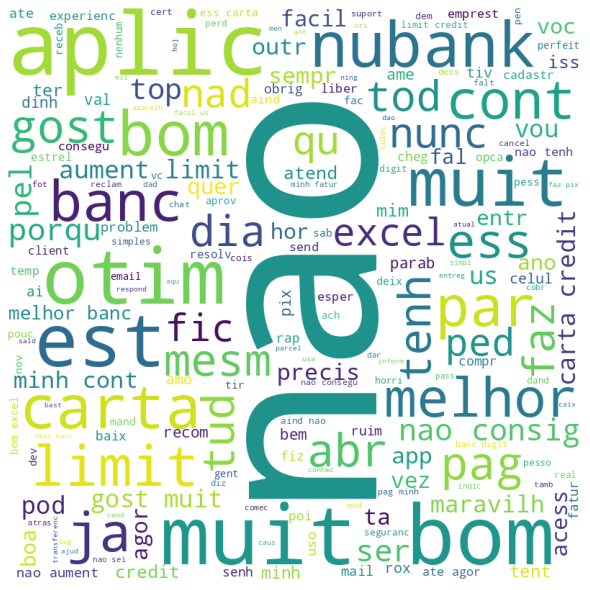

In [20]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

comment_words = ''
stopwords = set(STOPWORDS)
stopwords.update(["a", "e", "i", "o", "u", "da", "em", "meu", "minha", "mais", "menos", "você", "de", "ao", "os", "para", "vai", "sim", "não", "que", "eu", "ele", "ela", "pra", "pro", "na", "no", "muito"])

# iterate through the json file
for val in data['junction']:
	
	# typecaste each val to string
	val = str(val)

	# split the value
	tokens = val.split()
	
	# Converts each token into lowercase
	for i in range(len(tokens)):
		tokens[i] = tokens[i].lower()
	
	comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
				background_color ='white',
				stopwords = stopwords,
				min_font_size = 10).generate(comment_words)

# plot the WordCloud image					
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()


### Information extraction

In [9]:
import spacy
from spacy.matcher import PhraseMatcher

nlp = spacy.load('pt_core_news_sm')

def informationExtraction(text):
    evaluations = []
    doc = nlp(text)
    
    securityTerms = ['segur', 'roub', 'clon', 'senh', 'acess']
    patterns = [nlp(term) for term in securityTerms]
    
    #Ver utilização do add_patterns juntamente com o entity_ruler (otimização)
    matcher = PhraseMatcher(nlp.vocab) 
    matcher.add("SECURITY_PATTERN", patterns)
    
    matches = matcher(doc)
    
    for i in range(0,len(matches)):
        token = doc[matches[i][1]:matches[i][2]]
        evaluations.append(str(token))
            
    return evaluations

data['extracted_reviews'] = data['junction'].apply(informationExtraction)

In [10]:
for i in range(len(data)):
    if len(data.loc[i,'extracted_reviews'])!=0:
        print(data.loc[i,'cleaned_reviews'])

a nubank veio piorando muito esses dias, agora voce tem que colocar dinheiro no cartao para poder usar, alem de sempre ter que colocar senha para ter acesso que as vezes nao funciona e eu acabo ficando sem acesso ao aplicativo.
desde hoje meu aplicativo entra em uma tela falando pra eu colocar a mesma senha do meu celular, eu coloco, da certo, mas volta pra uma tela perguntando se eu quero usar esda opcao, e vira um ciclo eterno, numa sai desta tela, mesmo eu pondo a senha
sugerir (ou seria obrigar?) que a senha do aplicativo seja a mesma do aparelho e ser muito sem nocao, pra dizer o minimo
toda vez que mudo a senha do celular preciso desinstalar o aplicativo porque comeca a dar erro e nao aceita a senha nova
aplicativo acusa erro o tempo todo ao tentar entrar com a senha, sendo que a senha ta certa. tem que ficar desinslando e instalando para da certo.
pessimo. o aplicativo so deixa voce usar se tiver senha de bloqueio no seu celular. o aplicativo deveria ter o proprio bloqueio indep